In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split

## Modelling position distributions for a quantum harmonic oscillator given only a single timestamp

In [2]:
df = pd.read_csv('quantum_harmonic_oscillator_data.csv')
print("Dataset shape ", df.shape)

# Selecting the first 100 columns
initial = df.iloc[:, :100].to_numpy()

# Selecting final 100 columns
final = df.iloc[:, 100:].to_numpy()
print("Initial data shape ", initial.shape)

Dataset shape  (14000, 200)
Initial data shape  (14000, 100)


In [3]:
marker_1 = int(0.2 * len(df))
marker_2 = int(0.8 * len(df))

# Split into training and testing data
train_data = df.iloc[marker_1:marker_2]
test_data = pd.concat([df.iloc[:marker_1], df.iloc[marker_2:]])

# Verifying shapes
print("Shape of train_data:", train_data.shape)
print("Shape of test_data:", test_data.shape)
print()

# TRAINING DATA
feat_train = train_data.iloc[:, :100].values.reshape(-1, 100)  # the first 100 columns are features
targ_train = train_data.iloc[:, 100:].values.reshape(-1, 100)  # the next 100 columns are targets

# TESTING DATA
feat_test = test_data.iloc[:, :100].values.reshape(-1, 100)
targ_test = test_data.iloc[:, 100:].values.reshape(-1, 100)

# Verifying shapes after reshaping
print("Shape of feat_train:", feat_train.shape)
print("Shape of targ_train:", targ_train.shape)
print("Shape of feat_test:", feat_test.shape)
print("Shape of targ_test:", targ_test.shape)

Shape of train_data: (8400, 200)
Shape of test_data: (5600, 200)

Shape of feat_train: (8400, 100)
Shape of targ_train: (8400, 100)
Shape of feat_test: (5600, 100)
Shape of targ_test: (5600, 100)


In [4]:
# Convert strings to complex numbers
F_train = np.vectorize(complex)(feat_train)
T_train = np.vectorize(complex)(targ_train)
F_test = np.vectorize(complex)(feat_test)
T_test= np.vectorize(complex)(targ_test)

In [5]:
# Convert numpy arrays to PyTorch tensors
F_train_tensor = torch.tensor(F_train, dtype = torch.complex64)
T_train_tensor = torch.tensor(T_train, dtype = torch.complex64)
F_test_tensor = torch.tensor(F_test, dtype = torch.complex64)
T_test_tensor = torch.tensor(T_test, dtype = torch.complex64)
print(F_train_tensor.shape)
print(F_train_tensor.dtype)

torch.Size([8400, 100])
torch.complex64


In [6]:
torch.seed()

class SGDRegression(nn.Module):
    def __init__(self):
        super(SGDRegression, self).__init__()
        self.fc1 = nn.Linear(100, 400, dtype = torch.complex64)  # Input layer [1 input]
        self.fc2 = nn.Linear(400, 50,  dtype = torch.complex64)  # Hidden layer 1
        self.fc3 = nn.Linear(50, 400,  dtype = torch.complex64)  # Hidden layer 2
        self.fc4 = nn.Linear(400, 100,  dtype = torch.complex64)   # Output layer [1 output]

    def forward(self, x):
        x = torch.tanh(self.fc1(x))  
        x = torch.tanh(self.fc2(x)) 
        x = torch.tanh(self.fc3(x))  
        x = self.fc4(x)
        return x

In [7]:
class CustomLoss(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, data_preds, data_targs):
        # data loss
        diff = data_preds - data_targs
        diff_dag = torch.conj(diff)
        loss_data = torch.mean(diff*diff_dag)
        return loss_data.float()


In [8]:
#from tensorboardX import SummaryWriter
BATCH_SIZE = 16
EPOCHS = 15
LR = 0.001

train_data = torch.utils.data.TensorDataset(F_train_tensor, T_train_tensor)
data_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)

size = len(data_loader.dataset)
model = SGDRegression()
loss_fn = CustomLoss() 
alpha = 0.5
optimizer = optim.Adam(model.parameters(), lr=LR)
losses = []
    
for epoch in range(EPOCHS):
    for batch, (input_data, output_data) in enumerate(data_loader):

        pred = model(input_data)
        loss = loss_fn(pred, output_data)
        losses.append(loss.item())
            
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()        
        
print("Done")

/tmp/ipykernel_4069849/947843043.py:13: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at ../aten/src/ATen/native/Copy.cpp:299.)
  return loss_data.float()


Done


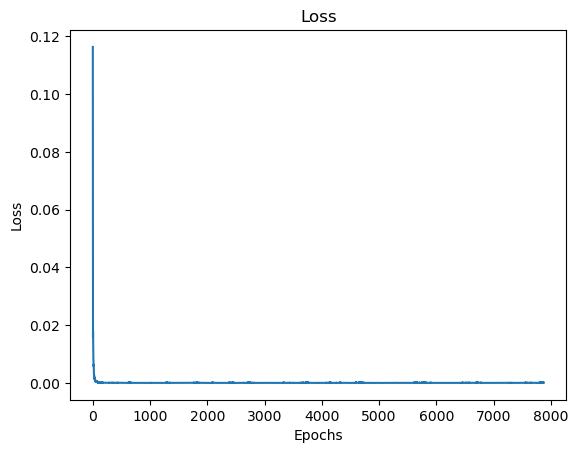

In [9]:
EPOCHS = list(range(1, len(losses) + 1))
plt.plot(EPOCHS, losses)
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

[4807 6414 5996 4812 6763]


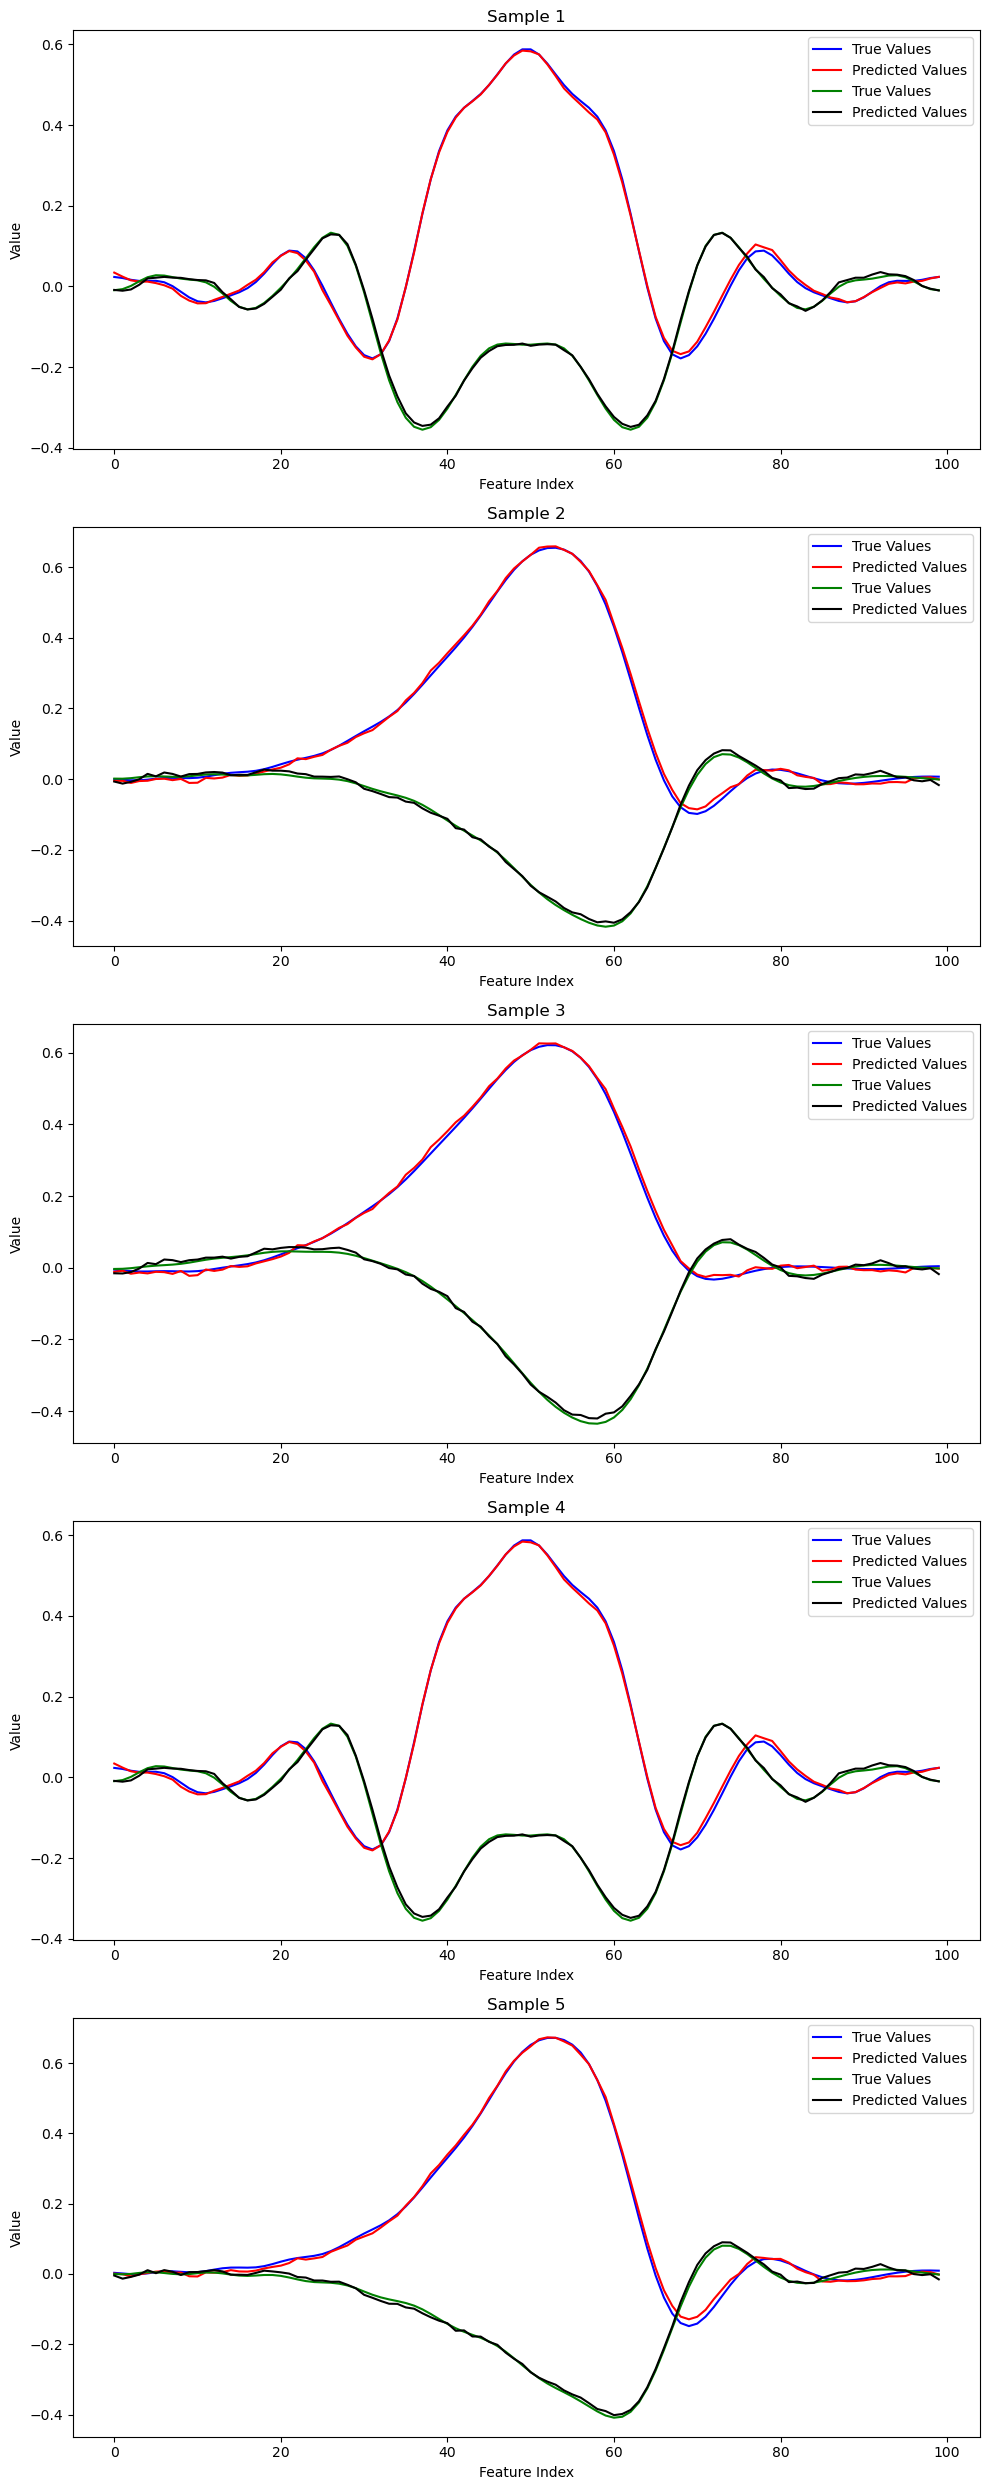

In [33]:
# Randomly select a subset of the test data
#Evaluating
model.eval()
with torch.no_grad():
    test_pred = model(F_test_tensor)
    train_pred = model(F_train_tensor)
test_pred = test_pred.numpy()
train_pred = train_pred.numpy()

num_samples = 5  # Number of samples to plot
indices = np.random.choice(F_train_tensor.shape[0], num_samples)
print(indices)
# Get the true and predicted values for these indices
true_values = T_train_tensor[indices].numpy()
predicted_values = train_pred[indices]

# Plotting the results
fig, axs = plt.subplots(num_samples, 1, figsize=(10, 5 * num_samples))

for i in range(num_samples):
    axs[i].plot(range(100), true_values[i], color='blue', label='True Values')
    axs[i].plot(range(100), predicted_values[i], color='red', label='Predicted Values')
    axs[i].plot(range(100), true_values[i].imag, color='green', label='True Values')
    axs[i].plot(range(100), predicted_values[i].imag, color='black', label='Predicted Values')
    axs[i].set_title(f'Sample {i+1}')
    axs[i].set_xlabel('Feature Index')
    axs[i].set_ylabel('Value')
    axs[i].legend()

plt.tight_layout()
plt.show()

/tmp/ipykernel_4069849/734476445.py:11: ComplexWarning: Casting complex values to real discards the imaginary part
  losses[i] = loss


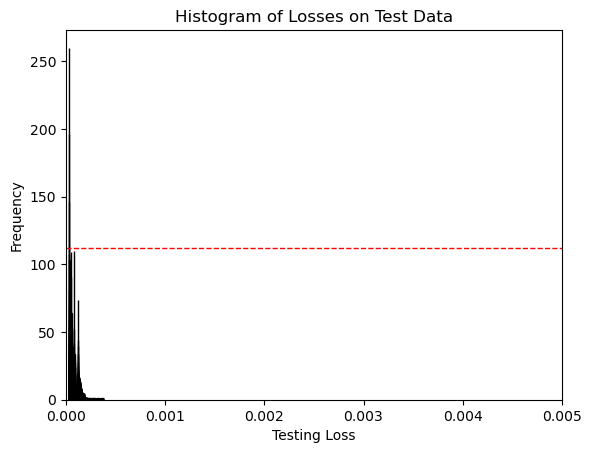

In [34]:
num = F_train_tensor.shape[0]
losses = np.zeros(num)


for i in range(num):
    predicted = train_pred[i]
    actual = T_train_tensor[i].numpy()
    diff = predicted - actual
    diff_conj = np.conjugate(diff)
    loss = (1 / 100) * np.sum(diff * diff_conj)
    losses[i] = loss


# Plotting the histogram of losses
plt.hist(losses, bins=1000, edgecolor='black')
average_frequency = np.mean(n)
plt.axhline(average_frequency, color='red', linestyle='dashed', linewidth=1)

plt.title('Histogram of Losses on Test Data')
plt.xlabel('Testing Loss')
plt.ylabel('Frequency')
plt.xlim(0, 0.005)
plt.show()


In [35]:
print(np.sum(losses)/num)

8.342957982483011e-05
